# 1) Write your own custom head and try training the pet recognizer with it. See if you can get a better result than fastai’s default.


In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)/'images'

def is_cat(x):
    return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

fastai deafult:

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 175MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.176736,0.031039,0.989851,00:47


epoch,train_loss,valid_loss,accuracy,time
0,0.070876,0.020659,0.991204,00:48


custom head:

In [ ]:
encoder = create_body(resnet34(weights=ResNet34_Weights.DEFAULT), cut=-2)

after checking (printing) the encoder we see that it outputs 512 features

In [ ]:
head = create_head(512, 2)

In [ ]:
class PetRecogniser(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)

In [ ]:
model = PetRecogniser(encoder, head)

In [ ]:
def splitter(model):
    return [params(model.encoder), params(model.head)]

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
                    splitter=splitter, metrics=accuracy)
learn.freeze()

In [ ]:
learn.fit_one_cycle(1, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.057912,0.012095,0.997294,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.021936,0.010291,0.997294,00:50


My custom head yields better results than fastai deafult

# 2) Try switching between AdaptiveConcatPool2d and AdaptiveAvgPool2d in a CNN head and see what difference it makes.

In [ ]:
head_avgp = create_head(512, 2, concat_pool=False)
avg_pool_model = PetRecogniser(encoder, head_avgp)

def splitter(model):
    return [params(avg_pool_model.encoder), params(avg_pool_model.head)]

learn = Learner(dls, avg_pool_model, loss_func=CrossEntropyLossFlat(),
                    splitter=splitter, metrics=accuracy)
learn.freeze()

learn.fit_one_cycle(1, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.053904,0.011444,0.996617,00:51


epoch,train_loss,valid_loss,accuracy,time
0,0.017411,0.009695,0.997294,00:53


it is hard to tell which approach works better as the model is already very close to 100% accuracy

# 3) Write your own custom splitter to create a separate parameter group for every ResNet block, and a separate group for the stem. Try training with it, and see if it improves the pet recognizer.

I will also consider a more difficult problem as the pet recogniser is already very close to 100%

In [ ]:
encoder = create_body(resnet34(weights=ResNet34_Weights.DEFAULT), cut=-2)
head = create_head(512, 2)

model = PetRecogniser(encoder, head)
def splitter(model):
    # Extract stem and blocks
    stem = list(model.encoder.children())[:4]
    blocks = list(model.encoder.children())[4:]

    # Combine stem parameters into one group
    stem_params = []
    for layer in stem:
        stem_params += list(layer.parameters())

    # Return parameter groups: [stem, b1, b2, b3, b4, head]
    return [stem_params, *map(params, blocks), params(model.head)]

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),
                    splitter=splitter, metrics=accuracy)
learn.freeze()

learn.fit_one_cycle(1, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.069731,0.017828,0.993911,00:50


epoch,train_loss,valid_loss,accuracy,time
0,0.016187,0.012139,0.995940,00:53


Same as above, no significant improvement happened as the model is already very accurate. Let's try with the problem of determining whether 2 pictures belong to the same class

In [ ]:
files = get_image_files(path)

class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2),
                          title=same_breed, ctx=ctx)

def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]}

    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)

    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]),same

splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)
tls = TfmdLists(files, tfm, splits=splits)
dls = tls.dataloaders(after_item=[Resize(224), ToTensor],
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head

    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [ ]:
head = create_head(512*2, 2, ps=0.5)

In [ ]:
model = SiameseModel(encoder, head)

In [ ]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out, targ.long())

In [ ]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [ ]:
learn = Learner(dls, model, loss_func=loss_func,
                splitter=siamese_splitter, metrics=accuracy)
learn.freeze()

learn.fit_one_cycle(4, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.526542,0.392251,0.814614,01:42
1,0.397697,0.239484,0.912720,01:29
2,0.290053,0.207073,0.921516,01:31
3,0.253508,0.200487,0.925575,01:31


epoch,train_loss,valid_loss,accuracy,time
0,0.243092,0.191754,0.930988,01:33
1,0.230754,0.181784,0.935724,01:33
2,0.211978,0.181789,0.929635,01:35
3,0.224155,0.180753,0.935724,01:33


and with separating stem and blocks:

In [ ]:
learn = Learner(dls, model, loss_func=loss_func,
                splitter=splitter, metrics=accuracy)
learn.freeze()

learn.fit_one_cycle(4, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.282693,0.258563,0.901894,01:29
1,0.282856,0.227343,0.918133,01:29
2,0.233448,0.179553,0.940460,01:28
3,0.219876,0.169137,0.947226,01:31


epoch,train_loss,valid_loss,accuracy,time
0,0.190561,0.163100,0.945196,01:35
1,0.192365,0.147409,0.953315,01:36
2,0.174783,0.141009,0.954668,01:36
3,0.162290,0.139924,0.955345,01:38


This is significantly better result, however its hard to tell what is the impact of different splitter as the model got much better starting weights (90% vs 80% accuracy) also it finished the first half of the training with frozen body with just as good result as the final model in the book

To get more (hopefully) informative results, let's try again the avgpool layer instead of concatpool (maxpool + avgpool)

In [ ]:
head = create_head(512*2, 2, concat_pool=False)

In [ ]:
model = SiameseModel(encoder, head)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func,
                splitter=siamese_splitter, metrics=accuracy)
learn.freeze()

learn.fit_one_cycle(4, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.395046,0.263107,0.905954,01:35
1,0.289821,0.189671,0.937077,01:32
2,0.217533,0.159037,0.946549,01:32
3,0.197500,0.151341,0.951286,01:31


epoch,train_loss,valid_loss,accuracy,time
0,0.190909,0.137975,0.953315,01:37
1,0.177323,0.138555,0.951286,01:36
2,0.181164,0.142279,0.953315,01:39
3,0.180276,0.134627,0.951286,01:37


this one had even better start - 95 % accuracy, however it ended up with worse result, therefore I conclude that concatpool + more splitting is better than avgpool + simple split

In [ ]:
learn = Learner(dls, model, loss_func=loss_func,
                splitter=splitter, metrics=accuracy)
learn.freeze()

learn.fit_one_cycle(4, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.214203,0.185097,0.939107,01:40
1,0.237841,0.184272,0.936401,01:30
2,0.210490,0.151107,0.949932,01:36
3,0.185948,0.147389,0.952639,01:42


epoch,train_loss,valid_loss,accuracy,time
0,0.179647,0.134647,0.955345,01:37
1,0.161861,0.137753,0.954668,01:38
2,0.156036,0.116809,0.960081,01:36
3,0.156596,0.116636,0.961434,01:37


This one is even better, plus it is quite intuitive that adding more channels - getting more weights (concatpool), without leading to overfiting is leading to better models, more slicing is giving more thoroughly lower learning rates to first more general layers, and higher to later - and therefore more specific layers. All things considered concatpool seems better than avgpool, and splitting into smaller components also yields better results.

# 4) Create a custom head using nearest neighbor interpolation and use it to do segmentation on CamVid.


In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

In [3]:
encoder = create_body(resnet34(weights=ResNet34_Weights.DEFAULT), cut=-2)

In [4]:
def upconv(ni, nf):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=3, padding=1),
        nn.BatchNorm2d(nf),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='nearest')
    )

In [5]:
head = nn.Sequential(
    upconv(512, 256),
    upconv(256, 128),
    upconv(128, 64),
    upconv(64, 32),
    upconv(32, 32),
)

In [6]:
class SegmentationModel(Module):
    def __init__(self, encoder, head):
        self.encoder, self.head = encoder, head

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x)

In [7]:
model = SegmentationModel(encoder, head)

In [8]:
def splitter(model):
    # Extract stem and blocks
    stem = list(model.encoder.children())[:4]
    blocks = list(model.encoder.children())[4:]

    # Combine stem parameters into one group
    stem_params = []
    for layer in stem:
        stem_params += list(layer.parameters())

    # Return parameter groups: [stem, b1, b2, b3, b4, head]
    return [stem_params, *map(params, blocks), params(model.head)]

In [9]:
def loss_func(out, targ):
    return nn.CrossEntropyLoss()(out, targ.long())

Dice:                                                                      
2*|A⋂B| / (|A|+|B|)                                                            
A - predictions                                                                 
B - targets

In [23]:
learn = Learner(dls, model, loss_func=loss_func, splitter=splitter, metrics=Dice)
learn.freeze()

SuggestedLRs(valley=0.0014454397605732083)

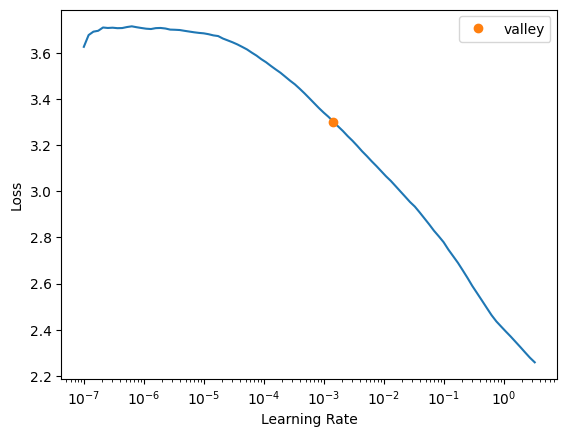

In [11]:
learn.lr_find()

In [24]:
learn.fit_one_cycle(10, 5e-2, wd=0.5)

epoch,train_loss,valid_loss,dice,time
0,0.749408,1.060481,17.865675,00:00
1,0.825423,1.423070,17.773689,00:00
2,0.911748,1.575285,17.485799,00:01
3,0.922781,1.236492,17.675685,00:01
4,0.920265,1.213209,17.218961,00:00
5,0.912120,1.320804,14.530354,00:00
6,0.893924,1.248202,16.332447,00:00
7,0.866418,1.017053,17.079315,00:00
8,0.837138,0.897224,17.881799,00:00
9,0.810944,0.862073,18.031993,00:00


In [25]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6,1e-3), wd=0.5)

epoch,train_loss,valid_loss,dice,time
0,0.723162,0.931886,17.845077,00:00
1,0.753025,1.185389,17.521279,00:00
2,0.772029,1.107045,17.210346,00:00
3,0.769905,0.928446,17.784718,00:00
4,0.761357,0.868952,17.789795,00:00
5,0.746843,0.861636,17.859810,00:01
6,0.731711,0.865468,17.802045,00:01
7,0.718924,0.838005,17.941259,00:00
8,0.707771,0.822983,18.000491,00:00
9,0.699023,0.821666,17.998026,00:00


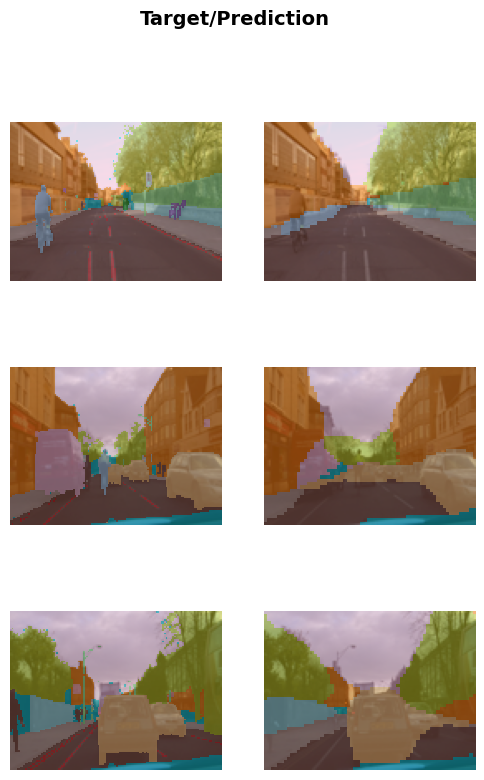

In [26]:
def custom_show_results(learn, max_n=3):
    learn.model.eval()  # Set the model to evaluation mode
    b = dls.one_batch()
    x, y = b
    preds = learn.model(x)
    preds = preds.argmax(dim=1)  # Convert to (batch_size, height, width)

    dls.show_results(b, preds, max_n=max_n)

custom_show_results(learn)

Fastai deafult:

In [31]:
learn = unet_learner(dls, resnet34, metrics=Dice)
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice,time
0,3.575218,1.989828,13.207201,00:01


epoch,train_loss,valid_loss,dice,time
0,1.660365,1.454926,15.096644,00:01
1,1.493623,1.217285,15.290907,00:01
2,1.364439,1.059009,17.078131,00:01
3,1.232516,0.988278,17.827095,00:01
4,1.114578,0.841987,17.396858,00:01
5,1.009536,0.741758,18.200204,00:01
6,0.919956,0.739341,18.044643,00:01
7,0.842997,0.695103,18.363032,00:01
8,0.778913,0.702014,18.091267,00:01
9,0.727036,0.698008,18.123382,00:02


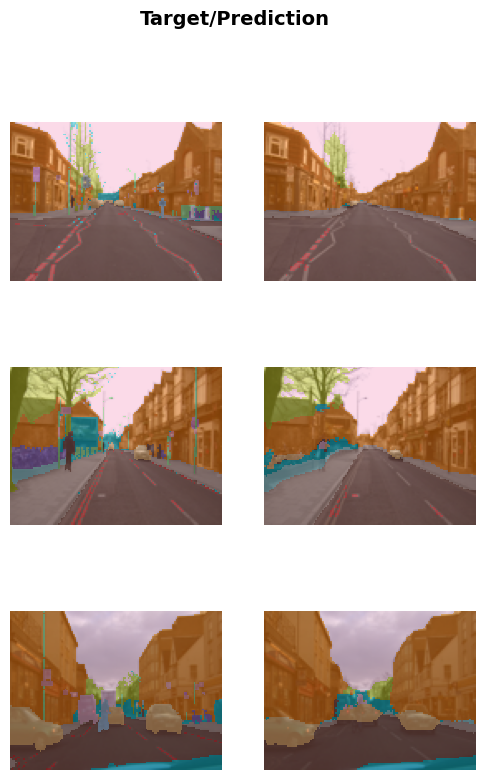

In [32]:
custom_show_results(learn)

As Unet is more sofisticated architecture than what I have done, it clearly yields better results